## Часть 2. Обучение нейросети и расчет ее качества.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import cv2
from sklearn.preprocessing import OneHotEncoder
import csv
import random
from tensorflow.keras.models import load_model 
from collections import Counter
from scipy import ndimage
from PIL import Image

In [3]:
fonts_sample = pd.read_csv('fonts_sample.csv')
fonts_sample = fonts_sample['Font'].tolist()
print('\u001b[38;5;19m', 'Выведем список используемых шрифтов:', '\u001b[0m')
for i in sorted(fonts_sample):
    print('\u001b[38;5;19m', i, '\u001b[0m')

 Выведем список используемых шрифтов: 
 Aguante 
 Alumni Sans Collegiate One Italic 
 Alumni Sans Collegiate One Regular 
 Ambidexter 
 Aref Ruqaa Ink Bold 
 Aref Ruqaa Ink Regular 
 BRASS MONO Bold 
 BRASS MONO Bold Italic 
 BRASS MONO Bold Regular 
 BRASS MONO Italic 
 Better VCR 5.2 
 Ganesha Type Regular 
 Ghastly Panic 
 Realest Extended 
 Tana Uncial SP 


**По результатам первой части иследования получены изображения букв и символов предоставленных шрифтов. Присутствуют малозначимые символы изображения которых могут не идентифицироваться с конкретным шрифтом. Использование их при построении модели приведет к неточностям. Создадим список наименований этих символов и удалим их из данных для обучения.**

In [4]:
excess_index=[]
excess_foto = [410, 488, 566, 644, 732, 972, 973, 987]
for  i in excess_foto:
    excess_index.append(i-1)

In [5]:
excess_foto = [[26,43], [55,69], [132,142], [209,224], [288,298], [300,304], [341,358],  [395,408], [472,486], [550,564], 
               [628,642], [706,717], [723,726], [785,799], [837, 851], [880,883], [892,897], [900,909], [972,985]]
for  i in excess_foto:
    for n in range(i[0]-1, i[1]):
        excess_index.append(n)

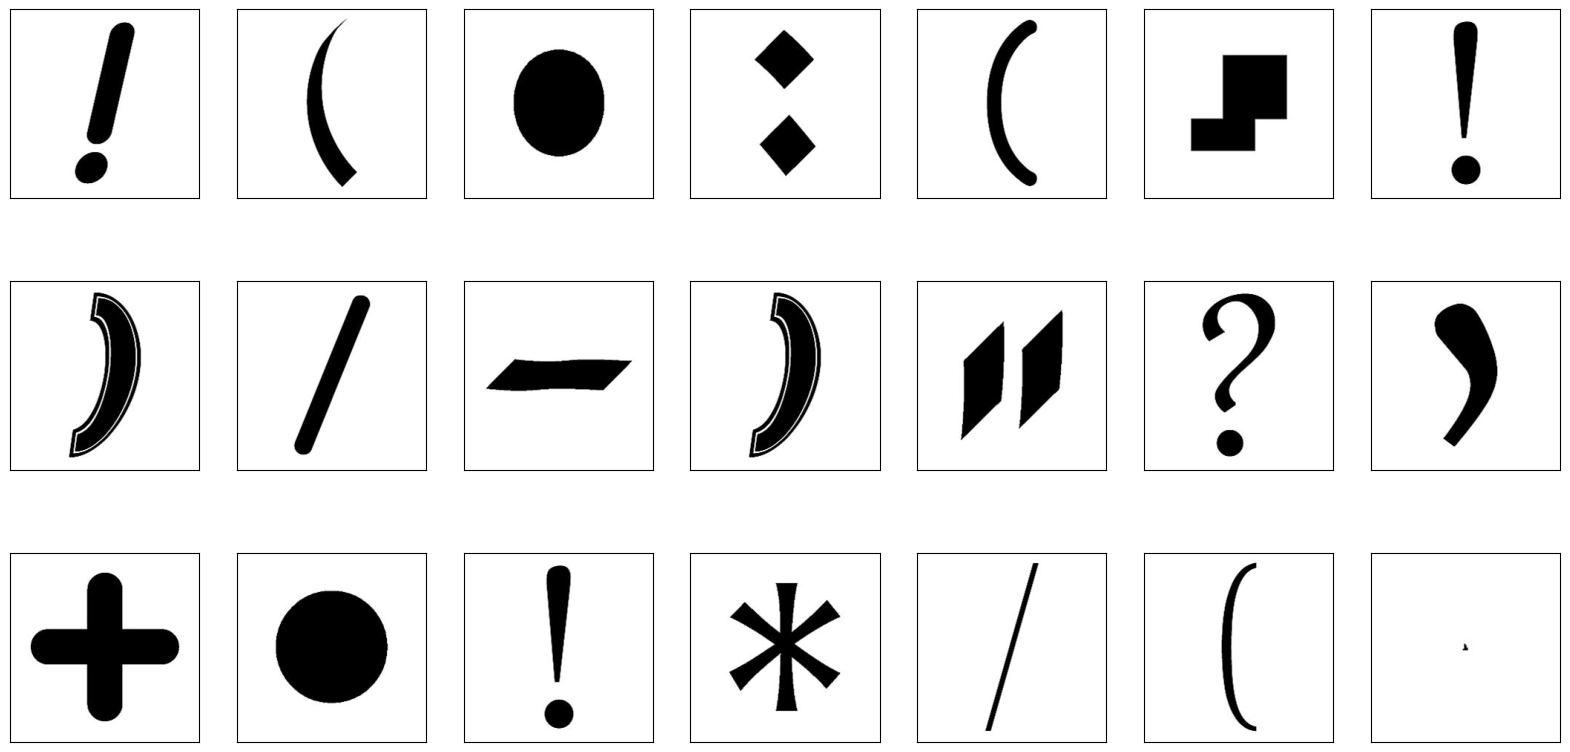

In [6]:
plt.figure(figsize=(20,10))
for i in range(21):
    num = random.choice(excess_index)
    image_path = 'fonts_sample_img/'+str(num+1)+'.jpg'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')

In [7]:
df_fonts = pd.read_csv('df_fonts.csv')
display(df_fonts.head().style.background_gradient(cmap='Blues', axis=0))

,Letter,Font
0,1.jpg,Aguante
1,2.jpg,Aguante
2,3.jpg,Aguante
3,4.jpg,Aguante
4,5.jpg,Aguante


In [8]:
data = df_fonts
data = data.drop(index=excess_index)
images_list = []
for i in range(0, len(df_fonts)):
    if i not in excess_index:
        img_path = 'fonts_sample_img/'+str(i+1)+'.jpg'
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images_list.append(img)
    else:
        continue

In [9]:
display(data['Font'].value_counts().to_frame().style.background_gradient(cmap='Blues', axis=0))

,count
Font,
Alumni Sans Collegiate One Regular,66
Realest Extended,64
Ambidexter,63
Alumni Sans Collegiate One Italic,62
BRASS MONO Bold,62
BRASS MONO Bold Italic,62
BRASS MONO Bold Regular,62
BRASS MONO Italic,62
Better VCR 5.2,62


**Наблюдаем дисбаланс классов. Проведем пересемплирование, дополнив выборки до максимального значения, продублировав символы из каждого шрифта.**

In [10]:
data = data.reset_index()
del data['index']
max_count_name = data['Font'].mode()[0]

In [11]:
s = len(df_fonts)
max_count = Counter(data['Font'])[max_count_name]
fonts_sample_k = tuple(fonts_sample)
l = 1
p = 0
for k in sorted(fonts_sample_k):
    
    count_old = Counter(df_fonts['Font'])[k]
    count = Counter(data['Font'])[k]

    t = p
    for i in range(1, max_count-count+1):
        
        while i + t - 1 in excess_index:
            t += 1
        data_1=pd.DataFrame([{"Letter":str(i+t)+'.jpg' ,"Font":k}])
        data=pd.concat([data,data_1],ignore_index=True)
        image_path = 'fonts_sample_img/'+str(i+t)+'.jpg'
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images_list.append(img)
        cv2.imwrite('fonts_sample_img_new/'+str(s+l)+'.jpg', img)
        l += 1
    p += count_old

In [12]:
print(len(data))

990


In [13]:
print(len(images_list))

990


In [14]:
display(data['Font'].value_counts().to_frame().style.background_gradient(cmap='Blues', axis=0))

,count
Font,
Aguante,66
Alumni Sans Collegiate One Italic,66
Alumni Sans Collegiate One Regular,66
Ambidexter,66
Aref Ruqaa Ink Bold,66
Aref Ruqaa Ink Regular,66
BRASS MONO Bold,66
BRASS MONO Bold Italic,66
BRASS MONO Bold Regular,66


**Проведем аугментацию добавив изображения с поворотом. Добавим также изображения с коррекций пикселей приведя потом к общему размеру картинки 256 на 256. Это моделирует получаемые изображения при распознавании на разных масштабах скриншота.**

(256, 256)


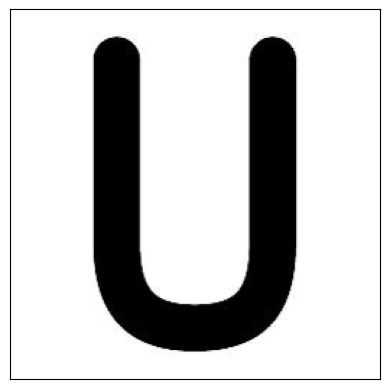

In [15]:
n = len(images_list)
num = random.randint(1, n)
plt.imshow(images_list[n-num], cmap='gray')
print(img.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)

(256, 256)


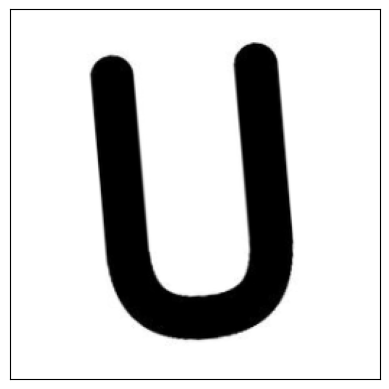

In [16]:
for i in range(1, n+1):
    img = images_list[i-1]
    a = img.shape[0]
    img = ndimage.rotate(img, 5, cval=255, reshape=True)
    img = cv2.resize(img, (a, a))
    images_list.append(img)
plt.imshow(images_list[len(images_list)-num], cmap='gray')
print(img.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)

(256, 256)


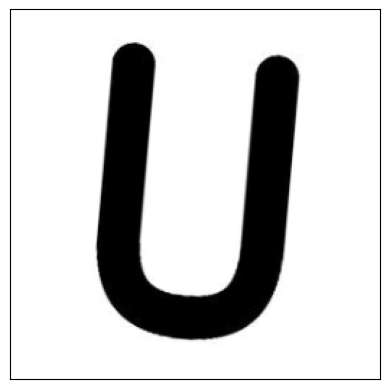

In [17]:
for i in range(1, n+1):
    img = images_list[i-1]
    a = img.shape[0]
    img = ndimage.rotate(img, -5, cval=255, reshape=True)
    img = cv2.resize(img, (a, a))
    images_list.append(img)
plt.imshow(images_list[len(images_list)-num], cmap='gray')
print(img.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)

(256, 256)


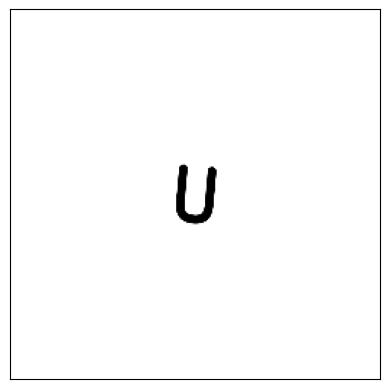

In [18]:
k = 0.2
n = len(images_list)
for i in range(1, n+1):
    img = images_list[i-1]
    ln = int((256/k-256)/2)
    img = cv2.copyMakeBorder(img, ln, ln, ln, ln,cv2.BORDER_CONSTANT,value=(255,255,255))
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
    images_list.append(img)
plt.imshow(images_list[len(images_list)-num], cmap='gray')
print(img.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)

(256, 256)


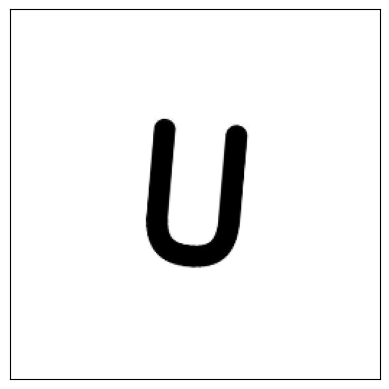

In [19]:
k = 0.5
for i in range(1, n+1):
    img = images_list[i-1]
    ln = int((256/k-256)/2)
    img = cv2.copyMakeBorder(img, ln, ln, ln, ln,cv2.BORDER_CONSTANT,value=(255,255,255))
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
    images_list.append(img)
plt.imshow(images_list[len(images_list)-num], cmap='gray')
print(img.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)

(256, 256)


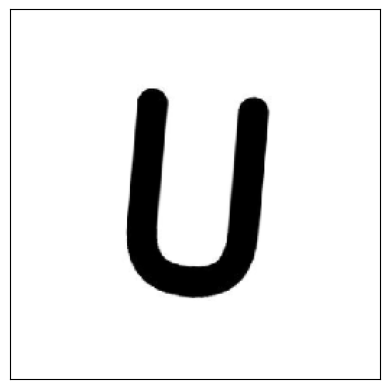

In [20]:
k = 0.7
for i in range(1, n+1):
    img = images_list[i-1]
    ln = int((256/k-256)/2)
    img = cv2.copyMakeBorder(img, ln, ln, ln, ln,cv2.BORDER_CONSTANT,value=(255,255,255))
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
    images_list.append(img)
plt.imshow(images_list[len(images_list)-num], cmap='gray')
print(img.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)

(256, 256)


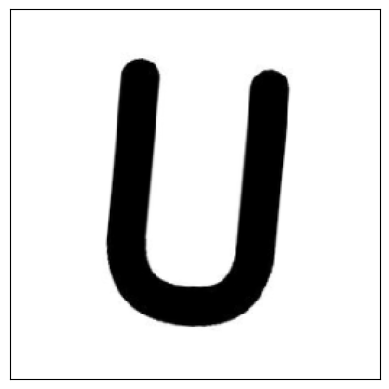

In [21]:
k = 0.9
for i in range(1, n+1):
    img = images_list[i-1]
    ln = int((256/k-256)/2)
    img = cv2.copyMakeBorder(img, ln, ln, ln, ln,cv2.BORDER_CONSTANT,value=(255,255,255))
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
    images_list.append(img)
plt.imshow(images_list[len(images_list)-num], cmap='gray')
print(img.shape)
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [22]:
print(len(images_list))

14850


In [23]:
df = data
for i in range(14):
    data = pd.concat([data, df])

In [24]:
print(len(data))

14850


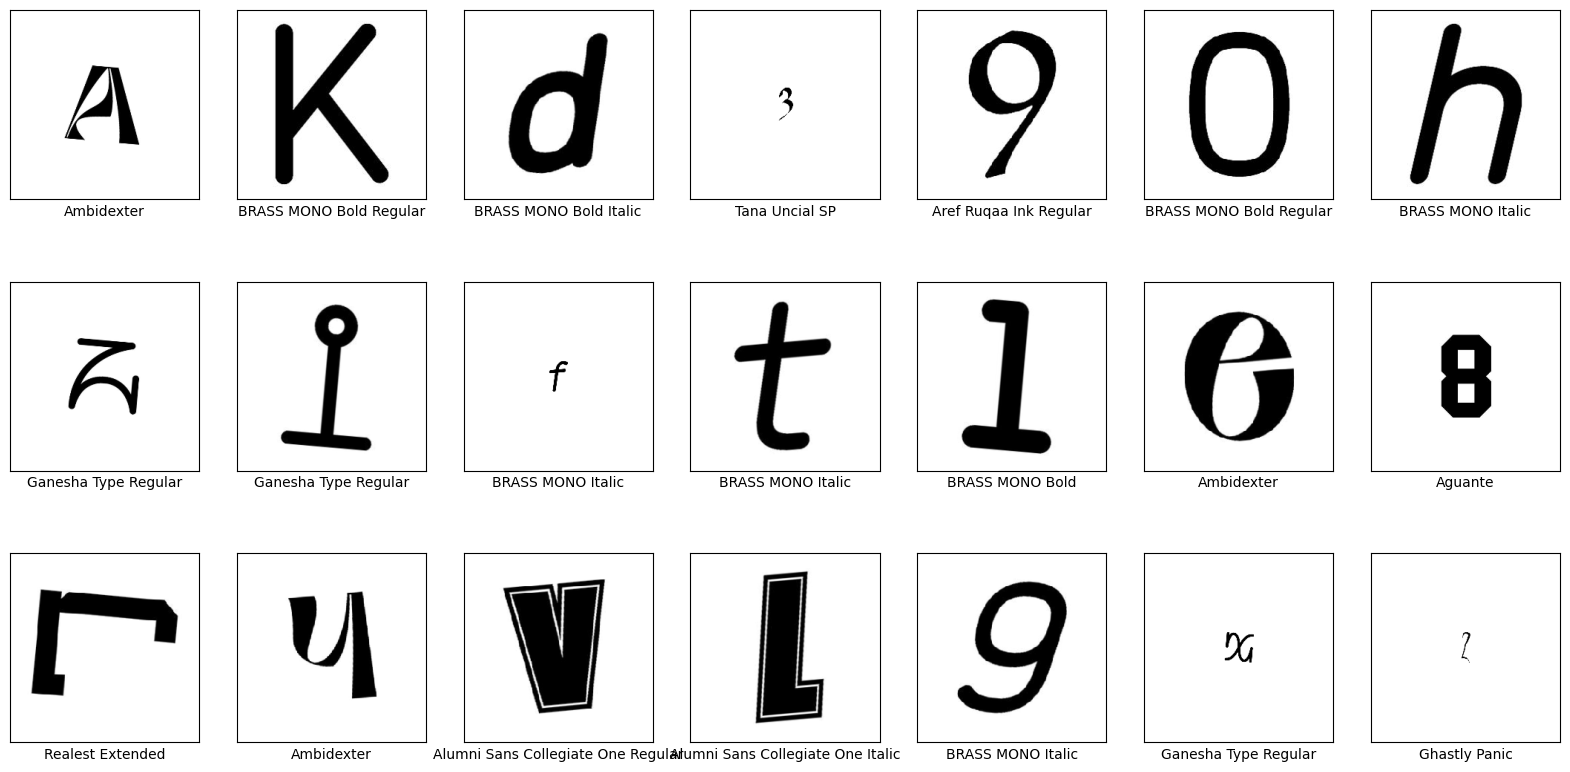

In [25]:
labels = list(data['Font'])
plt.figure(figsize=(20,10))
for i in range(21):
    num = random.randint(0, len(data)-1)
    plt.subplot(3,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_list[num], cmap='gray')
    plt.xlabel(labels[num])

In [26]:
X = np.array(images_list)/255
X = X.astype('float64')

In [27]:
data = data['Font']
data = data.reset_index()
del data['index']

In [28]:
encoder = OneHotEncoder(handle_unknown='ignore') 
encoder_df = pd.DataFrame(encoder.fit_transform(data[['Font']]).toarray())
data_df = data.join(encoder_df)
data_df.drop('Font', axis=1, inplace= True )

In [29]:
data_new = data_df.values

In [30]:
(X_train, X_test, y_train, y_test) = train_test_split(X, data_new, test_size=0.2, random_state=42)

In [31]:
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)

In [32]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(15, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      29,491,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,522,703 (112.62 MB)

 Trainable params: 29,522,703 (112.62 MB)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train,
          epochs=30,
          validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 205s 543ms/step - accuracy: 0.4369 - loss: 1.7628 - precision: 0.7141 - val_accuracy: 0.8498 - val_loss: 0.4472 - val_precision: 0.9009
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 202s 544ms/step - accuracy: 0.9031 - loss: 0.2851 - precision: 0.9351 - val_accuracy: 0.8822 - val_loss: 0.3688 - val_precision: 0.8976
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 200s 539ms/step - accuracy: 0.9547 - loss: 0.1307 - precision: 0.9614 - val_accuracy: 0.9350 - val_loss: 0.1893 - val_precision: 0.9425
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 202s 542ms/step - accuracy: 0.9767 - loss: 0.0735 - precision: 0.9797 - val_accuracy: 0.9343 - val_loss: 0.2327 - val_precision: 0.9395
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 201s 539ms/step - accuracy: 0.9797 - loss: 0.0645 - precision: 0.9809 - val_accuracy: 0.9377 - val_loss: 0.2151 - val_precision: 0.9448
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 201s 541ms/step - accuracy: 0.9849 - loss: 0.0507 - precision: 0.9856 - val_accu

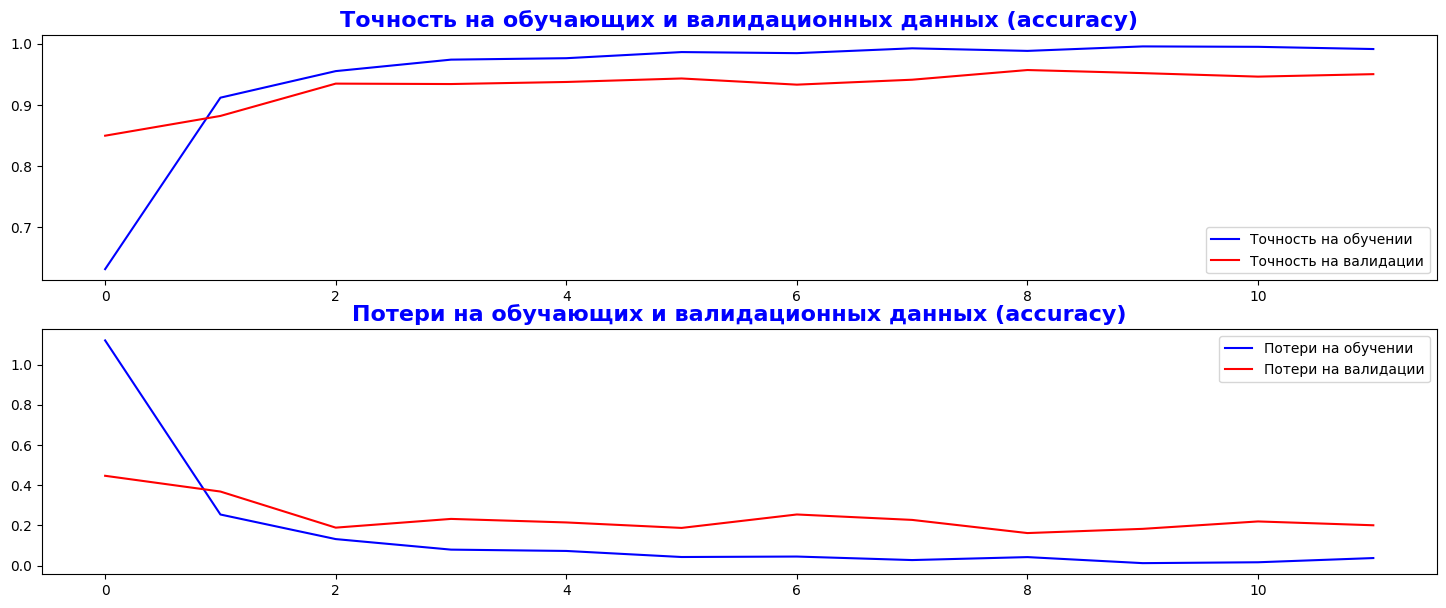

In [34]:
plt.figure(figsize=(18, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label = 'Точность на обучении', color='blue')
plt.plot(history.history['val_accuracy'], label = 'Точность на валидации', color='red')
plt.legend()
plt.title('Точность на обучающих и валидационных данных (accuracy)', fontsize=16, fontweight="bold", color='blue')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label = 'Потери на валидации', color='red')
plt.legend()
plt.title('Потери на обучающих и валидационных данных (accuracy)', fontsize=16, fontweight="bold", color='blue')
plt.show()

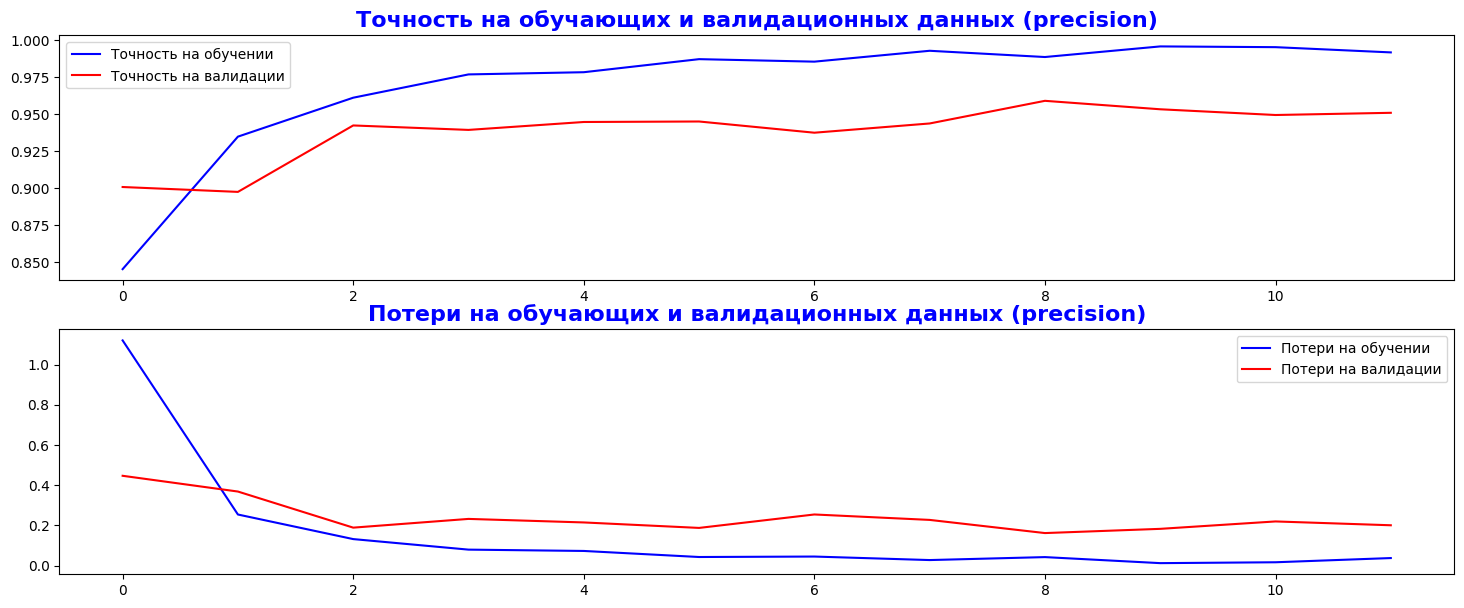

In [35]:
plt.figure(figsize=(18, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['precision'], label = 'Точность на обучении', color='blue')
plt.plot(history.history['val_precision'], label = 'Точность на валидации', color='red')
plt.legend()
plt.title('Точность на обучающих и валидационных данных (precision)', fontsize=16, fontweight="bold", color='blue')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label = 'Потери на валидации', color='red')
plt.legend()
plt.title('Потери на обучающих и валидационных данных (precision)', fontsize=16, fontweight="bold", color='blue')
plt.show()

In [36]:
keras.saving.save_model(model, 'model_font_recognition.keras')

In [37]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
auc=history.history['precision']
val_auc=history.history['val_precision']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [38]:
with open('data_loss.csv', 'a') as csv_file: 
    writer = csv.writer(csv_file) 
    writer.writerow(loss)

In [39]:
with open('data_val_loss.csv', 'a') as csv_file: 
    writer = csv.writer(csv_file) 
    writer.writerow(val_loss)

In [40]:
print('\u001b[38;5;19m', 'Точность на обучении max (accuracy) =', round(max(accuracy), 2), '\u001b[0m')

 Точность на обучении max (accuracy) = 1.0 


In [41]:
print('\u001b[38;5;19m', 'Точность на валидации max (accuracy) =', round(max(val_accuracy), 2), '\u001b[0m')

 Точность на валидации max (accuracy) = 0.96 


In [42]:
print('\u001b[38;5;19m', 'Точность на обучении max (precision) =', round(max(auc), 2), '\u001b[0m')

 Точность на обучении max (precision) = 1.0 


In [43]:
print('\u001b[38;5;19m', 'Точность на валидации max (precision) =', round(max(val_auc), 2), '\u001b[0m')

 Точность на валидации max (precision) = 0.96 


**Можно заметить на графиках, что точность на тренировочном и валидационном достаточно близки, и наша модель достигла хорошей точности на валидационном наборе данных. Точность на тренировочном наборе достигает практически 100%. В дальнейшем мы будем распознавать текст, состоящий из достаточного количества букв. Если для более половины букв будет распознан одинаковый шрифт, то мы примем это как распознавание всего текста.**